In [ ]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
SIZE = 256
num_images = 936

In [ ]:

image_directory = '/content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/train_patches'
mask_directory = '/content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/mask_patches'

In [ ]:
image_names = glob.glob("/content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/train_patches/*.tif")
image_names.sort()
print(image_names)
image_names_subset = image_names[0:num_images]
images = [cv2.imread(img, 0) for img in image_names_subset]
image_dataset = np.array(images)
#image_dataset = np.expand_dims(image_dataset, axis = 3)

[]


In [ ]:
print(image_dataset.shape)

(0,)


In [ ]:

mask_names = glob.glob("/content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/mask_patches/*.tif")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]

masks = []
for mask in mask_names_subset:
    if os.path.exists(mask):
        print(f"Reading mask image: {mask}")
        mask_img = cv2.imread(mask, 0)

        if mask_img is not None:
            mask_img[mask_img > 0] = 255
            masks.append(mask_img)
        else:
            print(f"Error reading mask image: {mask}")
    else:
        print(f"Mask image does not exist: {mask}")

mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis=3)


Reading mask image: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/mask_patches/image_0_00.tif
Reading mask image: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/mask_patches/image_0_01.tif
Reading mask image: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/mask_patches/image_0_02.tif
Reading mask image: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/mask_patches/image_0_03.tif
Reading mask image: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/mask_patches/image_0_04.tif
Reading mask image: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/mask_patches/image_0_05.tif
Reading mask image: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/mask_patches/image_0_06.tif
Reading mask image: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/mask_patches/image_0_07.tif
Reading mask image: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/mask_patches/image_0

In [ ]:

print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (936, 256, 256, 1)
Mask data shape is:  (936, 256, 256, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0 255]


In [ ]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
mask_dataset = mask_dataset /255.  #PIxel values will be 0 or 1

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)

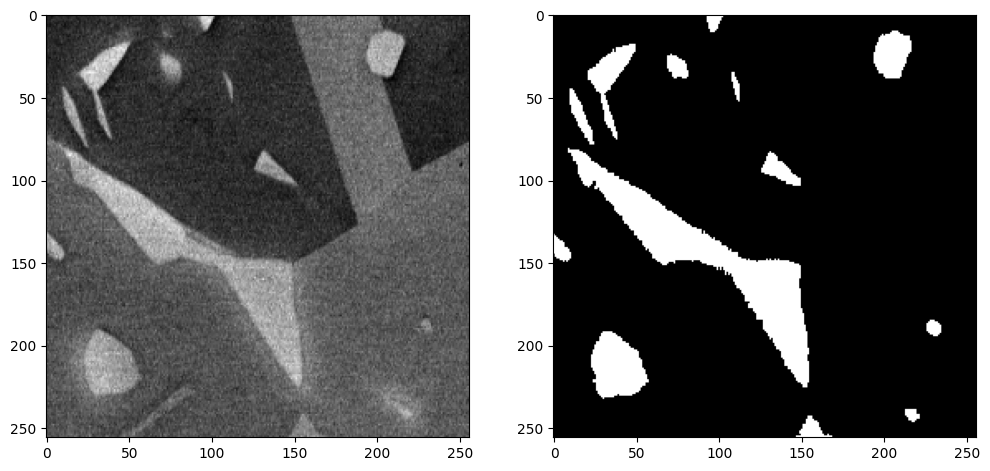

In [ ]:
#Sanity check, view few mages
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

In [ ]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:


IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)

(256, 256, 1)


In [ ]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                     

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Epoch 1/50
47/47 [==============================] - 90s 1s/step - loss: 0.3135 - accuracy: 0.8854 - val_loss: 93.7103 - val_accuracy: 0.8512
Epoch 2/50
47/47 [==============================] - 42s 890ms/step - loss: 0.1975 - accuracy: 0.9288 - val_loss: 2.6923 - val_accuracy: 0.5172
Epoch 3/50
47/47 [==============================] - 42s 894ms/step - loss: 0.1713 - accuracy: 0.9354 - val_loss: 0.3937 - val_accuracy: 0.8351
Epoch 4/50
47/47 [==============================] - 42s 893ms/step - loss: 0.1584 - accuracy: 0.9404 - val_loss: 0.3704 - val_accuracy: 0.8642
Epoch 5/50
47/47 [==============================] - 42s 894ms/step - loss: 0.1470 - accuracy: 0.9440 - val_loss: 0.7346 - val_accuracy: 0.8517
Epoch 6/50
47/47 [==============================] - 42s 895ms/step - loss: 0.1432 - accuracy: 0.9450 - val_loss: 0.4740 - val_accuracy: 0.8610
Epoch 7/50
47/47 [==============================] - 42s 895ms/step - loss: 0.1324 - accuracy: 0.9494 - val_loss: 0.6294 - val_accuracy: 0.8605
E

In [ ]:
#Save the model for future use
model.save('/content/drive/MyDrive/Colab Notebooks/unet/models/256Unet936img_50epochs_0,001lr.hdf5')

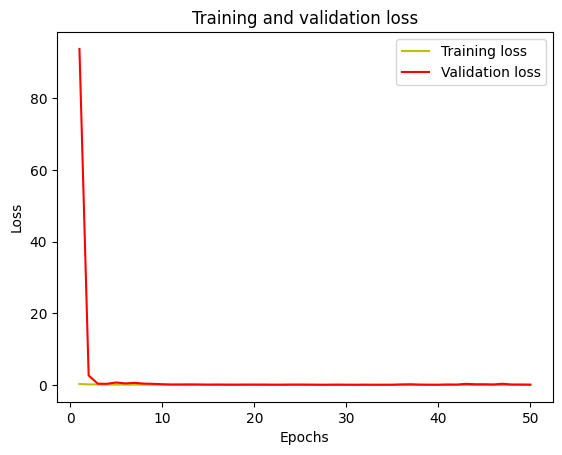

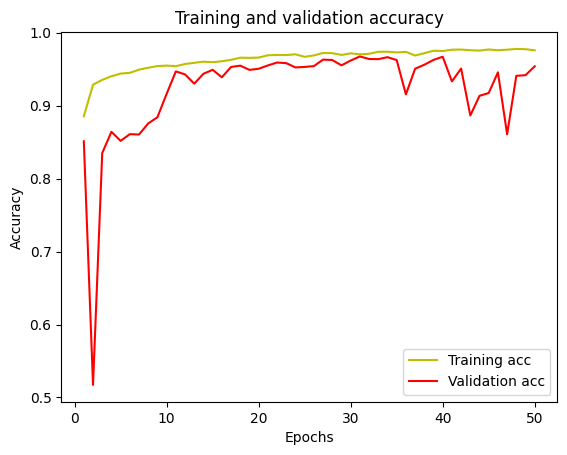

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/unet/images/model graphs/256Unet936img_50epochs_0,001lr_1.png')
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/unet/images/model graphs/256Unet936img_50epochs_0,001lr_2.png')
plt.show()



In [ ]:
#####test on different image######

In [ ]:
pip install patchify

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff

large_image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/unet/images/test_images/0900C_500h_area1.tif',0)
large_image=cv2.resize(large_image,(2048,2048))
large_image.shape

(2048, 2048)

In [ ]:
import cv2
import numpy as np
import os

def patchify_image(image, patch_size):
    height, width = image.shape
    patches = []

    # Iterate over the image in patches
    for y in range(0, height, patch_size):
        for x in range(0, width, patch_size):
            patch = image[y:y+patch_size, x:x+patch_size]
            patches.append(patch)

    return patches


# Set the patch size
patch_size = 256

# Patchify the image
patches = patchify_image(large_image, patch_size)

# Create a directory to save the patches
output_dir = '/content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches'
os.makedirs(output_dir, exist_ok=True)

# Save the patches into files
for i, patch in enumerate(patches):
    patch_filename = f'patch_{i}.tif'
    patch_path = os.path.join(output_dir, patch_filename)
    cv2.imwrite(patch_path, patch)

    print(f'Saved patch {i+1}/{len(patches)}: {patch_path}')


Saved patch 1/64: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches/patch_0.tif
Saved patch 2/64: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches/patch_1.tif
Saved patch 3/64: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches/patch_2.tif
Saved patch 4/64: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches/patch_3.tif
Saved patch 5/64: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches/patch_4.tif
Saved patch 6/64: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches/patch_5.tif
Saved patch 7/64: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches/patch_6.tif
Saved patch 8/64: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches/patch_7.tif
Saved patch 9/64: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches/patch_8.tif
Saved patch 10/64: /content/drive/MyD

In [ ]:
import glob
import cv2

# Assuming images are stored in the "images" directory and have .tif extension
image_directory = "/content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches"
image_files = glob.glob(f"{image_directory}/*.tif")

# Enumerate and process the image files
test_patches1=[]
for index, file_path in enumerate(image_files):
    # Read the image
    image = cv2.imread(file_path,0)
    image=np.array(image)
    image=np.expand_dims(image , axis=2)
    test_patches1.append(image)


    # Process the image
    # ...

    # Print the index and file path
    print(f"Image {index + 1}: {file_path}")
print(len(test_patches1))
test_patches1=np.array(test_patches1)
test_patches1=test_patches1/255.

Image 1: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches/patch_0.tif
Image 2: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches/patch_1.tif
Image 3: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches/patch_2.tif
Image 4: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches/patch_3.tif
Image 5: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches/patch_4.tif
Image 6: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches/patch_5.tif
Image 7: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches/patch_6.tif
Image 8: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches/patch_7.tif
Image 9: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches/patch_8.tif
Image 10: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches/patch_9.tif
Image 11: /content/

In [ ]:
IMG_HEIGHT = test_patches1.shape[1]
IMG_WIDTH  = test_patches1.shape[2]
IMG_CHANNELS = test_patches1.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

print(input_shape)

(256, 256, 1)


In [ ]:
from tensorflow.keras.models import load_model
model=load_model('/content/drive/MyDrive/Colab Notebooks/unet/models/256Unet936img_50epochs_0,001lr.hdf5')
prediction1=model.predict(test_patches1)
prediction_thresholded1=(prediction1>0.5).astype(np.uint8)
prediction_thresholded1.shape

2/2 [==============================] - 17s 11ms/step


(64, 256, 256, 1)

In [ ]:
reshaped_array1 = np.reshape(prediction_thresholded1, (8, 8, 256, 256, 1))
reshaped_array1 = np.squeeze(reshaped_array1)
reshaped_array1.shape

(8, 8, 256, 256)

In [ ]:
from patchify import unpatchify

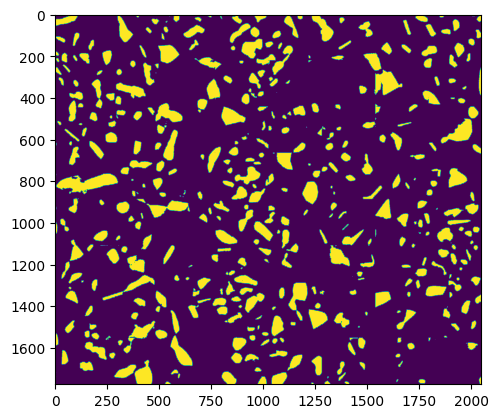

In [ ]:
reconst_image1=unpatchify(reshaped_array1,(2048,2048))
resized_image = cv2.resize(reconst_image1, (2048, 1776))
plt.imshow(resized_image)
plt.imsave("/content/drive/MyDrive/Colab Notebooks/unet/images/segmented_images/256unet_0900c_500h_area1_936im_50epoch_0,001lr.jpg",resized_image)

In [ ]:
######try on different image#####

Patched images saved temporarily and loaded into a list.
64
(256, 256, 1)
2/2 [==============================] - 17s 28ms/step


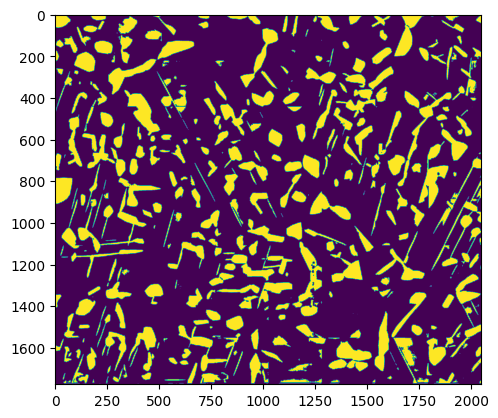

In [ ]:
large_img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/unet/images/test_images/0800C_0500h_area2.tif',cv2.IMREAD_COLOR)
large_img=cv2.resize(large_img,(2048,2048))
large_img = cv2.cvtColor(large_img, cv2.COLOR_RGB2BGR)
large_img=cv2.cvtColor(large_img,cv2.COLOR_BGR2GRAY)


!pip install patchify
from patchify import patchify,unpatchify
import pickle


# Define patch size and step
patch_size = (256, 256)
step = 256

# Extract patches from the large image
patches_img = patchify(large_img, patch_size, step=step)

# Create a directory to temporarily store patch files
temp_patch_dir = "temp_patch_files"
os.makedirs(temp_patch_dir, exist_ok=True)


# Save patches into temporary files
patch_filenames = []
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        single_patch_img = patches_img[i, j, :, :]
        #single_patch_img = cv2.cvtColor(single_patch_img, cv2.COLOR_GRAY2RGB)
        patch_filename = os.path.join(temp_patch_dir, f"patch_{i}_{j}.pickle")
        with open(patch_filename, "wb") as f:
            pickle.dump(single_patch_img, f)
        patch_filenames.append(patch_filename)



# Read the patches from files into a list
patch_list = []
for patch_filename in patch_filenames:
    with open(patch_filename, "rb") as f:
        patch = pickle.load(f)
        patch_list.append(patch)



# Cleanup - Delete temporary patch files
for patch_filename in patch_filenames:
    os.remove(patch_filename)
os.rmdir(temp_patch_dir)

print("Patched images saved temporarily and loaded into a list.")


print(len(patch_list))
patches=np.array(patch_list)
patches=patches/255.
patches=np.expand_dims(patches,axis=3)
patches.shape

IMG_HEIGHT = patches.shape[1]
IMG_WIDTH  = patches.shape[2]
IMG_CHANNELS = patches.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)


from tensorflow.keras.models import load_model
model=load_model('/content/drive/MyDrive/Colab Notebooks/unet/models/256Unet936img_50epochs_0,001lr.hdf5')
prediction1=model.predict(patches)
prediction_thresholded1=(prediction1>0.5).astype(np.uint8)
prediction_thresholded1.shape


reshaped_array1 = np.reshape(prediction_thresholded1, (8, 8, 256, 256, 1))
reshaped_array1 = np.squeeze(reshaped_array1)
reshaped_array1.shape


reconst_image1=unpatchify(reshaped_array1,(2048,2048))
resized_image = cv2.resize(reconst_image1, (2048, 1776))
plt.imshow(resized_image)
#plt.imsave("/content/drive/MyDrive/Colab Notebooks/unet/images/segmented_images/Unet128_0900c_500h_area4_1500img_epoch50.jpg",resized_image)

In [ ]:
plt.imsave("/content/drive/MyDrive/Colab Notebooks/unet/images/segmented_images/256unet_0800c_500h_area2_936im_50epoch_0,001lr.jpg",resized_image)